"""
SPEECh: Scalable Probabilistic Estimates of EV Charging

Code first published in October 2021.

Developed by Siobhan Powell (siobhan.powell@stanford.edu).
"""

In [ ]:
s3_bucket_folder_address = '' # contained the location of our data

In [1]:
import pandas as pd
import os
os.chdir('..')
from speech import DataSetConfigurations
from speech import SPEECh
from speech import SPEEChGeneralConfiguration
from speech import Plotting
import numpy as np
import matplotlib.pyplot as plt
from speech import LoadProfile

# Example plotting code:

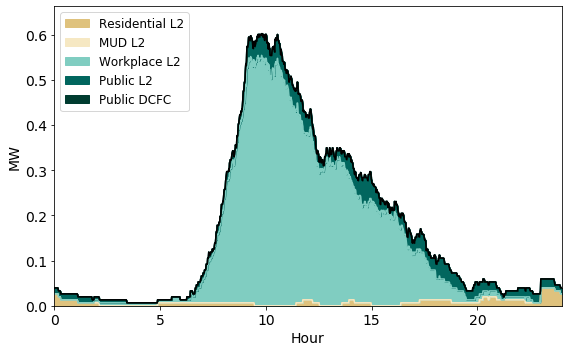

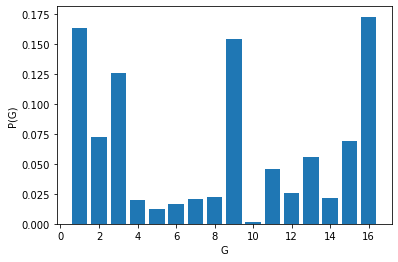

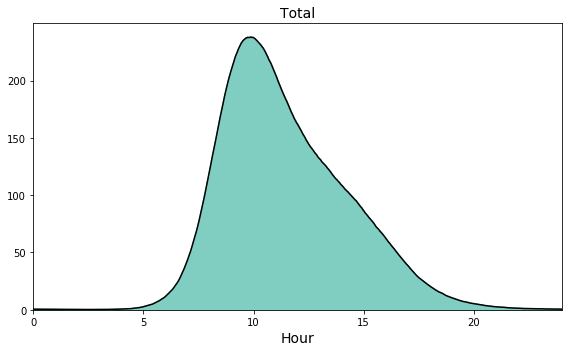

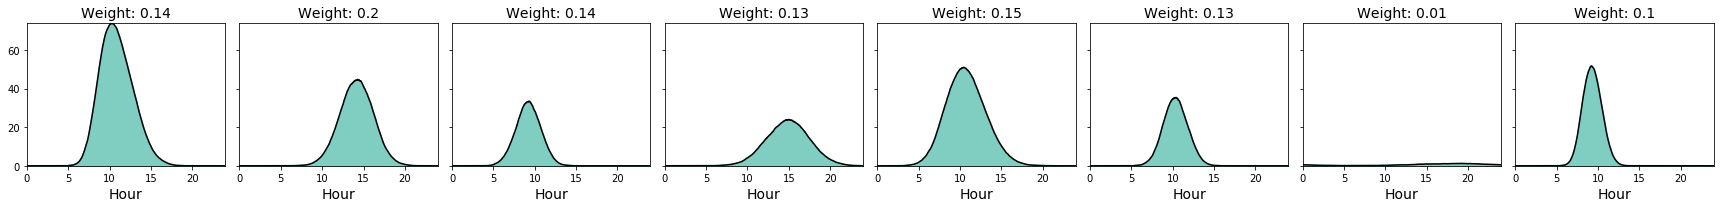

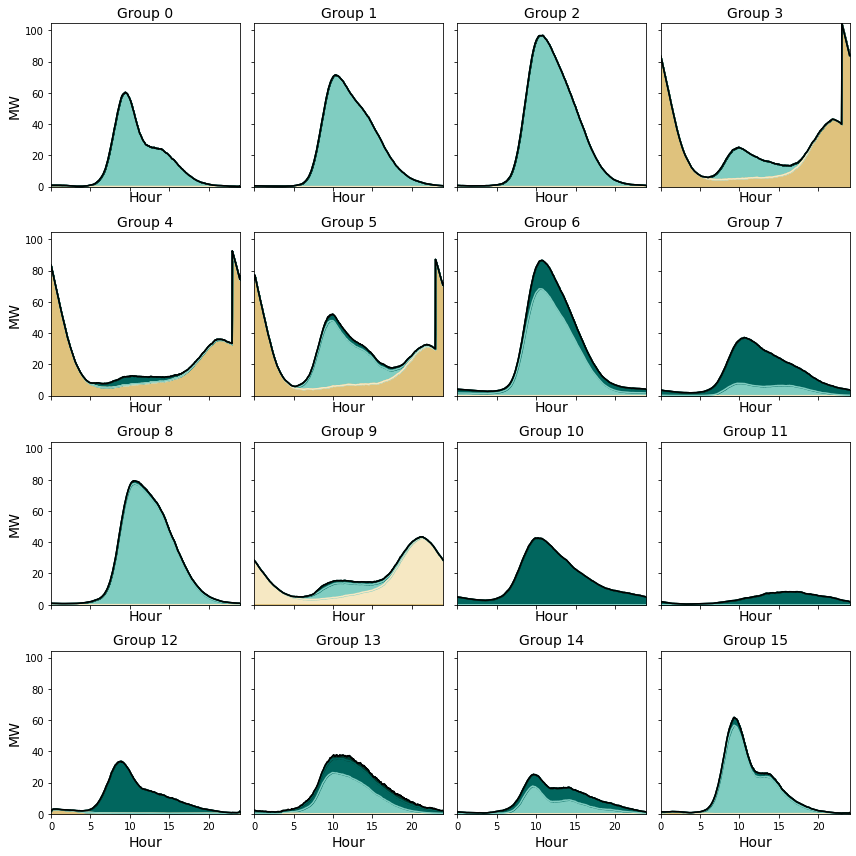

In [9]:
total_evs = 1000
weekday_option = 'weekday'

# data = DataSetConfigurations('NewData', ng=9)
data = DataSetConfigurations('Original16', ng=16)
speech = SPEECh(data)
config = SPEEChGeneralConfiguration(speech)
plots = Plotting(model, n=total_evs)  # plots total_evs (1000) in each group (i.e. ignores P(G))
plots.total(weekday='weekday', save_str='simple_example_plot.png')
plots.pg()
plots.sessions_components(g=1, cat='Work', weekday='weekday')
plots.groups(save_string=None)#'simple_example_groups.png')

# Groups plot for paper (more details) 

In [2]:
data = DataSetConfigurations('Original16', ng=16)
speech = SPEECh(data)
config = SPEEChGeneralConfiguration(speech)
config.num_evs(1e6)
config.groups()

In [3]:
def plot(ax, load_segments_array, load_segments_dict, title, scaler=1, ylab=False, ylabtext='', xlab=True, y1=True):

    patterns = {'Residential L2': '/', 'MUD L2': '///', 'Workplace L2': '\\', 'Public L2': 'x', 'Public DCFC': '.'}
    x = (1/60)*np.arange(0, 1440)
    mark = np.zeros(np.shape(x))
    scaling = scaler
    if np.max(scaling * load_segments_array) > 1000:
        scaling = (1 / 1000) * (1 / 1000)
        unit = 'GW'
    for key, val in load_segments_dict.items():
        ax.plot(x, scaling * (mark + val), label=key, color=data.colours[key])
        ax.fill_between(x, scaling * mark, scaling * (mark + val), hatch=patterns[key], edgecolor='grey', facecolor=data.colours[key])#color=data.colours[key])
        mark += val
    ax.plot(x, scaling * mark, 'k')
    ax.set_xlim([0, np.max(x)])
    if ylab:
        ax.set_ylabel(ylabtext, fontsize=20)
    if y1: 
        ax.set_ylim([0, 1.1])
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        if ylab:
            ax.set_yticklabels([0, 0.25, 0.5, 0.75, 1.0], fontsize=20)
        else:
            ax.set_yticklabels([])
    ax.set_xlim([0, 24])
    ax.set_xticks([0, 6, 12, 18])
    if xlab:
        ax.set_xlabel('Hour', fontsize=20)
        ax.set_xticklabels([0, 6, 12, 18], fontsize=20)
    else:
        ax.set_xticklabels([])
    ax.set_title(title, fontsize=18)
    
    ax.set_axisbelow(True)        
    ax.grid(alpha=0.7)

    return ax

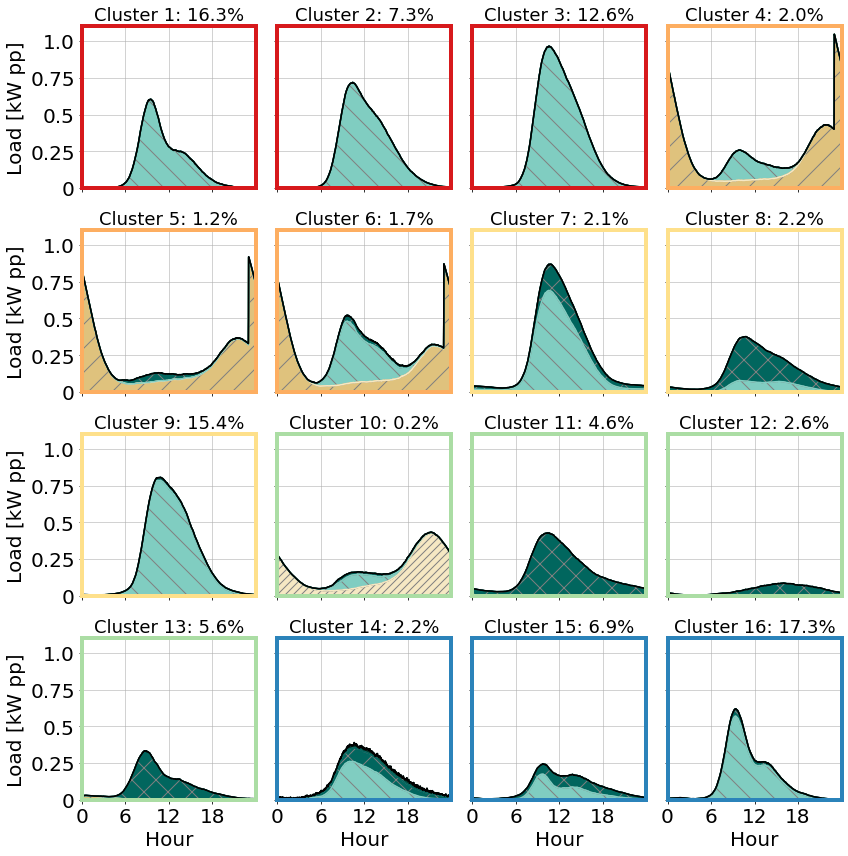

In [4]:
colors = ['#d7191c', '#fdae61', '#fee08b', '#abdda4', '#2b83ba']
color_mapping = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3, 12:3, 13:4, 14:4, 15:4}


n = 1e5
weekday = 'weekday'

nrow = int(np.ceil(np.divide(speech.data.ng, 4)))
fig, axes = plt.subplots(nrow, 4, sharex=False, sharey=False, figsize=(12, int(nrow*3)))
ymax = 0
for i in range(speech.data.ng):
    row = int(np.divide(i, 4))
    col = np.mod(i, 4)
    j = speech.data.cluster_reorder_dendtoac[i]
    config.group_configs[j].numbers(total_drivers=n)
    config.group_configs[j].load_gmms()
    model = LoadProfile(config, config.group_configs[j], weekday=weekday)
    model.calculate_load()
    if np.max(np.sum(model.load_segments_array, axis=1)) > ymax:
        ymax = np.max(np.sum(model.load_segments_array, axis=1))
    ylab = False
    if col == 0:
        ylab = True
    xlab = False
    if row == 3: 
        xlab = True
        
    labelnum = 'Cluster '+str(i+1)+': '+str(np.round(speech.pg.loc[j, 'pg']*100, 1))+'%'
    for name in ['bottom', 'top','left', 'right']:
        axes[row, col].spines[name].set_color(colors[color_mapping[i]])
        axes[row, col].spines[name].set_linewidth(4)
        
        
    axes[row, col] = plot(axes[row, col], model.load_segments_array, model.load_segments_dict, scaler=1/n, title=labelnum, ylab=ylab, xlab=xlab, ylabtext='Load [kW pp]')

plt.tight_layout()
plt.savefig('Figure3_groups_v2.pdf', bbox_inches='tight')
plt.show()

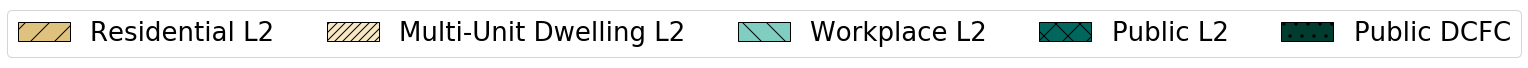

In [79]:
from matplotlib.patches import Patch

colours = ['#bf812d', '#dfc27d', '#f6e8c3', '#80cdc1',  '#01665e', '#003c30']
patterns = ['*', '/', '///', '\\', 'x', '.']

legend_elements = [#Patch(facecolor=colours[0], edgecolor=colours[0], alpha=0.7, label='Residential L1'), 
                  Patch(facecolor=colours[1], edgecolor='k', hatch=patterns[1], label='Residential L2'), 
                  Patch(facecolor=colours[2], edgecolor='k', hatch=patterns[2], label='Multi-Unit Dwelling L2'),
                  Patch(facecolor=colours[3], edgecolor='k', hatch=patterns[3], label='Workplace L2'),
                  Patch(facecolor=colours[4], edgecolor='k', hatch=patterns[4], label='Public L2'),
                  Patch(facecolor=colours[5], edgecolor='k', hatch=patterns[5], label='Public DCFC')]


fig, ax = plt.subplots(figsize=(12, 1))
ax.legend(handles=legend_elements, loc='center', fontsize=26, ncol=5)
plt.axis('off')
plt.savefig('legend_5col.pdf', bbox_inches='tight')
plt.show()

# About the Data

In [84]:
df = pd.read_csv(s3_bucket_folder_address+'sessions2019.csv', index_col=0)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [257]:
df.loc[df.loc[(df['POI Category'].isin(['Education', 'Fleet', 'Government (Fed, State)', 'Healthcare', 'Hospitality', 'Multifamily Commercial', 'Municipal', 'Parking', 'Parks and Recreation', 'Retail', 'Utility']))&(df['Max Power']<20)].index, 'type'] = 'Public L2'

In [258]:
df.loc[df.loc[(df['POI Category'].isin(['Education', 'Fleet', 'Government (Fed, State)', 'Healthcare', 'Hospitality', 'Multifamily Commercial', 'Municipal', 'Parking', 'Parks and Recreation', 'Retail', 'Utility']))&(df['Max Power']>=20)].index, 'type'] = 'Public DCFC'

In [252]:
df.loc[df.loc[(df['POI Category'].isin(['Workplace']))].index, 'type'] = 'Workplace'
df.loc[df.loc[(df['POI Category'].isin(['Single family residential']))].index, 'type'] = 'Residential L2'
df.loc[df.loc[(df['POI Category'].isin(['Multifamily Home Service']))].index, 'type'] = 'Multi-unit Dwelling L2'

In [259]:
df[df['type'].isna()]['POI Category']

Series([], Name: POI Category, dtype: object)

In [269]:
key_driver_info = pd.read_csv(s3_bucket_folder_address+'2019_unscaled_revised.csv', index_col=0)

In [270]:
subset = df[df['Driver ID'].isin(key_driver_info['Unique Driver ID'].values)]

In [272]:
names = []
vals = []
for key, val in subset['type'].value_counts().items():
    names.append(key)
    vals.append(val)

In [271]:
len(subset)

3993074

In [285]:
names

['Workplace',
 'Public L2',
 'Residential L2',
 'Public DCFC',
 'Multi-unit Dwelling L2']

In [303]:
vals/np.sum(vals)

array([0.7235075 , 0.1935003 , 0.07898852, 0.00242219, 0.00158149])

In [308]:
vals

[2889019, 772661, 315407, 9672, 6315]

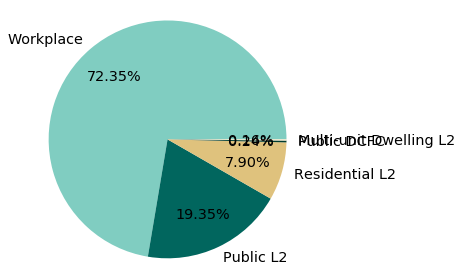

In [307]:
colors_pie = ['#80cdc1', '#01665e', '#dfc27d', '#003c30', '#f6e8c3']
explode = [0, 0, 0, 0, 0]#.2, 0.2]
plt.pie(vals, labels=names, 
        autopct='%1.2f%%' , pctdistance=0.7, labeldistance=1.1, colors=colors_pie, explode=explode, textprops={'size': 'x-large'})
plt.axis('equal')
# plt.setp(fontsize=15)
plt.tight_layout()
plt.savefig('data_pie.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# map of counties showing number of sessions in each
# counties of all sessions
# drivers used (38k): poi of sessions

In [87]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [179]:
cal = geopandas.read_file('/Users/siobhanpowell/Downloads/California Counties.geojson')

In [182]:
cts = df['County'].value_counts()
for key in cts.keys():
    cal.loc[cal[cal['name']==key[:-7]].index, 'Sessions'] = cts[key]


In [183]:
cal['Sessions_mn'] = (1/1000000)*cal['Sessions']

In [180]:
# cal = cal.to_crs(epsg=3857)

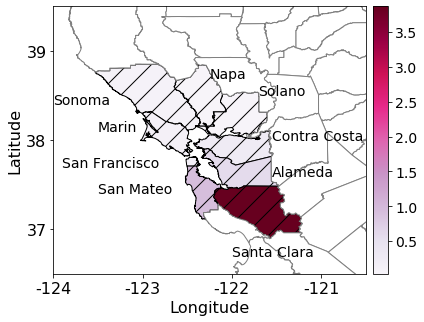

In [243]:
fig, ax = plt.subplots(figsize=(6, 8))
divider1 = make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cal.plot(column='Sessions_mn', ax=ax, cax=cax1, edgecolor='black', 
         legend=True, missing_kwds={'color':'white', 'edgecolor':'grey', 'hatch':None}, cmap='PuRd', hatch="/")
cax1.tick_params(labelsize=14)
# cax1.set_ylabel('Total Charging Sessions per County', labelsize=14)
ax.set_xlim([-124, -120.5])
ax.set_xticks([-124, -123, -122, -121])
ax.set_xticklabels([-124, -123, -122, -121], fontsize=16)
ax.set_yticks([37, 38, 39])
ax.set_yticklabels([37, 38, 39], fontsize=16)
ax.set_ylim([36.5, 39.5])
ax.text(-122, 36.7, 'Santa Clara', fontsize=14)
ax.text(-123.5, 37.4, 'San Mateo', fontsize=14)
ax.text(-123.9, 37.7, 'San Francisco', fontsize=14)
ax.text(-123.5, 38.1, 'Marin', fontsize=14)
ax.text(-124, 38.4, 'Sonoma', fontsize=14)
ax.text(-121.55, 37.6, 'Alameda', fontsize=14)
ax.text(-121.55, 38, 'Contra Costa', fontsize=14)
ax.text(-121.7, 38.5, 'Solano', fontsize=14)
ax.text(-122.25, 38.7, 'Napa', fontsize=14)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
plt.tight_layout()
plt.savefig('bay_area.pdf', bbox_inches='tight')
plt.show()

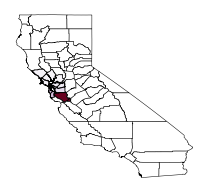

In [242]:
fig, ax = plt.subplots(figsize=(3,10))
cal.plot(column='Sessions_mn', ax=ax, cmap='PuRd', hatch="/", edgecolor='black', missing_kwds={'hatch':None, 'color':'white', 'edgecolor':'black', 'linewidth':0.5})
# plt.xlim([-124, -121])
# plt.ylim([36, 40])
plt.xticks([]); plt.yticks([])
ax.set_axis_off()
plt.tight_layout()
plt.savefig('full_CA.pdf', bbox_inches='tight')
plt.show()